I will use  statsmodels.MixedLM,to fit  a Linear Mixed Effects Model, which is appropriate because 

I have repeated observations per the Subject line , in different conditions ( day of week , month of the year )



In [1]:
#importing libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")

In [3]:
df.columns = df.columns.str.strip()

In [4]:
columns_to_drop = [ "translation", "CTR clean %","Month"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [5]:
# Convert to datetime
df['Sent_Date'] = pd.to_datetime(df['Sent_Date'], errors='coerce')

# Create a Month column (numeric)
df['Month'] = df['Sent_Date'].dt.month

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Sent_Date          1279 non-null   datetime64[ns]
 1   Day_of_week        1279 non-null   object        
 2   Category_name      1279 non-null   object        
 3   Main_Vs_REM        1279 non-null   object        
 4   Subject            1279 non-null   object        
 5   Sendings           1279 non-null   int64         
 6   OR                 1279 non-null   float64       
 7   Length_Of_subject  1279 non-null   int64         
 8   Personalization    1279 non-null   int64         
 9   Emoji              1279 non-null   int64         
 10  Urgency            1279 non-null   int64         
 11  Tone               1279 non-null   int64         
 12  Price_or_Discount  1279 non-null   int64         
 13  Imperative_Tone    1279 non-null   int64         
 14  Product 

In [7]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Replace numeric month values with names
df["Month"] = df["Month"].map(month_map)





In [8]:
categorical_columns = [
    'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month',
    "Subject"
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

In [9]:
df = df.sort_values("Sent_Date").reset_index(drop=True)

In [10]:
import pandas as pd
import numpy as np
from scipy import stats

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict

# Example usage
outliers = get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3)

print("Outliers in 'Sendings':")
display(outliers['Sendings'])

print("Outliers in 'OR%':")
display(outliers['OR'])

Outliers in 'Sendings':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Subject,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
707,2024-08-09,Wednesday,NL Interval,MAIN,✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,236976,0.0670,short,no,yes,yes,yes,yes,no,yes,30,August
734,2024-08-16,Wednesday,NL Interval,MAIN,Skynda dig! Väggdekor från endast 39kr!,237447,0.0792,short,no,no,yes,yes,yes,yes,yes,28,August
738,2024-08-18,Friday,NL Interval,MAIN,Upp till 58% rabatt på de mest älskade Canvast...,237300,0.0756,short,no,yes,no,yes,yes,no,yes,38,August
749,2024-08-20,Sunday,NL Interval,MAIN,Skynda dig | -54% på XXL-Canvastavla!,237087,0.0662,short,no,no,yes,yes,yes,yes,yes,24,August
754,2024-08-23,Wednesday,NL Interval,MAIN,Missa inte - Fotopresenter från endast 59 kr!,237672,0.0655,short,no,no,no,yes,yes,yes,yes,33,August
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2024-12-22,Friday,NL Interval,MAIN,Upp till 58% rabatt på de mest älskade Canvast...,244071,0.0666,short,no,yes,no,yes,yes,no,yes,38,December
1253,2024-12-24,Sunday,NL Interval,MAIN,Skynda dig | -54% på XXL-Canvastavla!,243981,0.0678,short,no,no,yes,yes,yes,yes,yes,24,December
1261,2024-12-27,Wednesday,NL Interval,MAIN,Missa inte - Fotopresenter från endast 59 kr!,244104,0.0699,short,no,no,no,yes,yes,yes,yes,33,December
1268,2024-12-29,Friday,NL Interval,MAIN,2 dagar | Canvastavlor från endast 185 kr!,243996,0.0667,short,no,no,yes,no,yes,no,yes,28,December


Outliers in 'OR%':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Subject,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
166,2024-03-01,Wednesday,NL Interval,MAIN,Dekorativ inredning för hemmet till de bästa p...,228,0.2763,short,no,no,no,no,no,no,yes,42,March
168,2024-03-01,Wednesday,NL Interval,MAIN,Premiumtryck upp till 78% rabatt!,186,0.2742,short,no,no,no,no,yes,no,yes,25,March
169,2024-03-01,Wednesday,NL Interval,MAIN,Personlig väggdekoration till fantastiska priser!,300,0.3200,short,no,no,no,no,no,no,yes,43,March
226,2024-03-22,Wednesday,NL Interval,MAIN,✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,1188,0.3157,short,no,yes,yes,yes,yes,no,yes,30,March
241,2024-03-29,Wednesday,NL Interval,MAIN,✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,1383,0.2625,short,no,yes,yes,yes,yes,no,yes,30,March
563,2024-07-02,Sunday,NL Interval,MAIN,Premiumtryck upp till 78% rabatt!,315,0.2571,short,no,no,no,no,yes,no,yes,25,July
565,2024-07-02,Sunday,NL Interval,MAIN,Personlig väggdekoration till fantastiska priser!,279,0.2581,short,no,no,no,no,no,no,yes,43,July
680,2024-08-02,Wednesday,NL Interval,MAIN,Dekorativ inredning för hemmet till de bästa p...,246,0.2927,short,no,no,no,no,no,no,yes,42,August
899,2024-10-01,Sunday,NL Interval,MAIN,Otroligt ✨ 3 XXL-format för 249 kr styck,345,0.2957,short,no,yes,no,yes,yes,no,no,26,October
1013,2024-11-01,Wednesday,NL Interval,MAIN,Otroligt ✨ 3 XXL-format för 249 kr styck,339,0.2566,short,no,yes,no,yes,yes,no,no,26,November


In [11]:
# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")

# Now df has Winsorized columns ready for modeling

Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


In [12]:
formula = (
    "OR ~ C(Day_of_week) + C(Category_name) + C(Main_Vs_REM) + "
    "C(Personalization) + C(Emoji) + C(Urgency) + C(Tone) + "
    "C(Price_or_Discount) + C(Imperative_Tone) + C(Product) + "
    "C(Length_Of_subject) + C(Month) + Letter_Count + Sendings  "
)

In [13]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
)


print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 1023, Test size: 256


In [14]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    formula=formula,
    data=train_df,
    groups=train_df["Subject"]
    
)
result = model.fit()
print(result.summary())

c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       OR       
No. Observations:         1023          Method:                   REML     
No. Groups:               37            Scale:                    0.0007   
Min. group size:          1             Log-Likelihood:           2137.3809
Max. group size:          72            Converged:                No       
Mean group size:          27.6                                             
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.193    0.018  10.775 0.000  0.158  0.228
C(Day_of_week)[T.Monday]        -0.003    0.010  -0.326 0.744 -0.022  0.016
C(Day_of_week)[T.Saturday]      -0.011    0.007  -1.695 0.090 -0.025  0.002
C(Day_of_week)[T.Sunday]       

c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 5.981161
  warnings.warn(msg, ConvergenceWarning)
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
#resid = result.resid
#fitted = result.fittedvalues

# Plot residuals vs fitted
#sns.scatterplot(x=fitted, y=resid)
#plt.axhline(0, color='red', linestyle='--')
#plt.title("Residuals vs Fitted Values")
#plt.xlabel("Fitted")
#plt.ylabel("Residuals")
#plt.show()

# Residual distribution
#sns.histplot(resid, kde=True)
#plt.title("Residual Distribution")
#plt.show()


In [16]:
# 3️⃣ Generate predictions on both train and test sets
train_df["predicted"] = result.predict(train_df)
test_df["predicted"]  = result.predict(test_df)

# 4️⃣ Evaluate model performance
def evaluate_performance(true, pred, label=""):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2   = r2_score(true, pred)
    print(f"{label} RMSE: {rmse:.4f}, R²: {r2:.3f}")
    return rmse, r2

evaluate_performance(train_df["OR"], train_df["predicted"], "Train")
evaluate_performance(test_df["OR"],  test_df["predicted"],  "Test")

Train RMSE: 0.0262, R²: 0.477
Test RMSE: 0.0284, R²: 0.409


(0.0284163232338072, 0.4087392594416457)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
train_pred = result.predict(train_df)
test_pred = result.predict(test_df)

# True values
y_train = train_df["OR"]
y_test = test_df["OR"]

# Compute metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0,1]
    bias = np.mean(y_pred - y_true)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # avoid division by zero
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - len(result.fe_params) - 1)
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2,
        "Adj R²": adj_r2,
        "Corr": corr,
        "Bias": bias
    }

train_metrics = regression_metrics(y_train, train_pred)
test_metrics = regression_metrics(y_test, test_pred)

print("Train metrics:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

Train metrics:
RMSE: 0.0262
MAE: 0.0194
MAPE (%): 16.4637
R²: 0.4772
Adj R²: 0.4614
Corr: 0.6913
Bias: -0.0007

Test metrics:
RMSE: 0.0284
MAE: 0.0214
MAPE (%): 18.0763
R²: 0.4087
Adj R²: 0.3299
Corr: 0.6401
Bias: -0.0001


In [ ]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# 1️⃣ Temporal split (95% train, 5% test)
split_date = df["Sent_Date"].quantile(0.95)

train_df = df[df["Sent_Date"] <= split_date].copy()
test_df  = df[df["Sent_Date"] > split_date].copy()



In [19]:
train_df = train_df.groupby("Subject").filter(lambda g: len(g) > 1)


C:\Users\TOWER-PC\AppData\Local\Temp\ipykernel_7424\3156646944.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby("Subject").filter(lambda g: len(g) > 1)


In [20]:
train_df["Subject"].value_counts().min()

0

In [21]:
train_df["Subject"].isna().sum()

0

In [22]:
print("NaNs in Subject:", train_df["Subject"].isna().sum())
print("Unique Subjects in train:", train_df["Subject"].nunique())
print("Min group size (nonzero only):", train_df["Subject"].value_counts().min())
print(train_df["Subject"].value_counts().head())


NaNs in Subject: 0
Unique Subjects in train: 28
Min group size (nonzero only): 0
Subject
Otroligt ✨ 3 XXL-format för 249 kr styck               84
Dekorativ inredning för hemmet till de bästa priset    83
Premiumtryck upp till 78% rabatt!                      83
Personlig väggdekoration till fantastiska priser!      82
✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!      73
Name: count, dtype: int64


In [23]:
model = smf.mixedlm(
    formula=formula,
    data=train_df,
    groups=train_df["Subject"]
)
result = model.fit()
print(result.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       OR       
No. Observations:         1210          Method:                   REML     
No. Groups:               28            Scale:                    0.0007   
Min. group size:          2             Log-Likelihood:           2525.4895
Max. group size:          84            Converged:                Yes      
Mean group size:          43.2                                             
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.186    0.020   9.274 0.000  0.147  0.226
C(Day_of_week)[T.Monday]        -0.006    0.008  -0.688 0.492 -0.022  0.011
C(Day_of_week)[T.Saturday]      -0.015    0.007  -2.135 0.033 -0.028 -0.001
C(Day_of_week)[T.Sunday]       

c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [24]:
# 3️⃣ Generate predictions on both train and test sets
train_df["predicted"] = result.predict(train_df)
test_df["predicted"]  = result.predict(test_df)

# 4️⃣ Evaluate model performance
def evaluate_performance(true, pred, label=""):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2   = r2_score(true, pred)
    print(f"{label} RMSE: {rmse:.4f}, R²: {r2:.3f}")
    return rmse, r2

evaluate_performance(train_df["OR"], train_df["predicted"], "Train")
evaluate_performance(test_df["OR"],  test_df["predicted"],  "Test")

Train RMSE: 0.0269, R²: 0.447
Test RMSE: 0.0239, R²: 0.457


(0.02387417469281248, 0.4572257611927656)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
train_pred = result.predict(train_df)
test_pred = result.predict(test_df)

# True values
y_train = train_df["OR"]
y_test = test_df["OR"]

# Compute metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0,1]
    bias = np.mean(y_pred - y_true)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # avoid division by zero
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - len(result.fe_params) - 1)
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2,
        "Adj R²": adj_r2,
        "Corr": corr,
        "Bias": bias
    }

train_metrics = regression_metrics(y_train, train_pred)
test_metrics = regression_metrics(y_test, test_pred)

print("Train metrics:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")


Train metrics:
RMSE: 0.0269
MAE: 0.0198
MAPE (%): 16.6600
R²: 0.4469
Adj R²: 0.4329
Corr: 0.6690
Bias: -0.0007

Test metrics:
RMSE: 0.0239
MAE: 0.0194
MAPE (%): 21.5061
R²: 0.4572
Adj R²: -0.0680
Corr: 0.7391
Bias: 0.0080


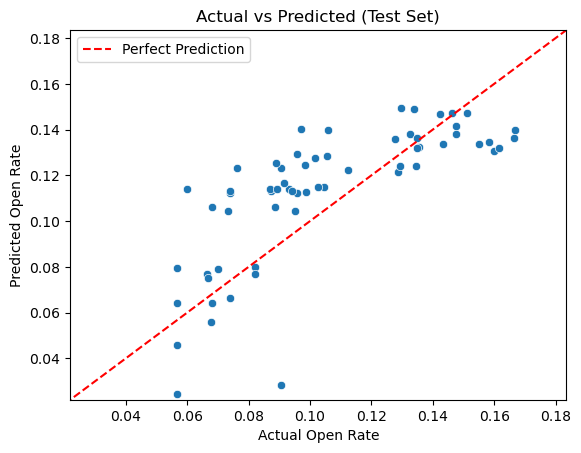

In [26]:
sns.scatterplot(x=y_test, y=test_pred)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')

# Dynamically set axis limits based on data
min_val = min(y_test.min(), test_pred.min()) * 0.9
max_val = max(y_test.max(), test_pred.max()) * 1.1
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.xlabel("Actual Open Rate")
plt.ylabel("Predicted Open Rate")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.show()


In [27]:
import pandas as pd

def predict_open_rate(model_result, new_data):
    """
    Predict open rate (OR) using a fitted MixedLM model and new input features.

    Parameters
    ----------
    model_result : statsmodels.regression.mixed_linear_model.MixedLMResults
        The fitted mixed-effects model.
    new_data : dict or pd.DataFrame
        A dictionary (single observation) or DataFrame of new inputs.

    Returns
    -------
    predictions : np.ndarray
        Predicted open rates.
    """
    # Convert dict input to DataFrame if needed
    if isinstance(new_data, dict):
        new_data = pd.DataFrame([new_data])

    # Ensure all categorical variables are treated as categories


    # Use the trained model to predict
    preds = model_result.predict(new_data)
    return preds


In [28]:
import pandas as pd

def interactive_predict_open_rate(model_result, train_df):
    """
    Interactively ask the user for input values for each feature and
    predict the open rate (OR) using the trained MixedLM model.
    """

    print("\n📬 Interactive Email Open Rate Predictor")
    print("Please enter/select values for each variable:\n")

    input_data = {}

    # Loop through each column except target or group columns
    exclude_cols = ["OR", "Subject", "Sent_Date"]
    for col in train_df.columns:
        if col in exclude_cols:
            continue

        # Get unique values if categorical
        uniques = train_df[col].dropna().unique()

        # If the column is categorical (string or few unique values)
        if train_df[col].dtype == "object" or len(uniques) < 15:
            print(f"\n➡️ {col} — choose one of the following:")
            for i, val in enumerate(uniques):
                print(f"   {i+1}. {val}")
            choice = input(f"Select 1–{len(uniques)} or type your own value: ")
            try:
                choice_idx = int(choice) - 1
                if 0 <= choice_idx < len(uniques):
                    value = uniques[choice_idx]
                else:
                    value = choice
            except:
                value = choice
            input_data[col] = value

        # If numeric
        else:
            example_val = round(train_df[col].mean(), 3)
            value = input(f"\n➡️ {col} (numeric, e.g. {example_val}): ")
            try:
                value = float(value)
            except:
                value = example_val
            input_data[col] = value

    # Convert to DataFrame
    new_data = pd.DataFrame([input_data])

    # Predict using model
    pred = model_result.predict(new_data)[0]

    print("\n🎯 Predicted Open Rate (OR): {:.2%}".format(pred))
    return pred, new_data


In [29]:
import pandas as pd
from ipywidgets import interact, Dropdown, IntSlider, FloatSlider, fixed
import ipywidgets as widgets

def interactive_open_rate_predictor(model_result, train_df):
    """
    Interactive widget to predict open rate for a new email subject line
    using a fitted MixedLM model and category options automatically derived from train_df.
    """

    # Identify categorical and numeric columns
    categorical_cols = [
        "Day_of_week", "Category_name", "Main_Vs_REM", "Personalization",
        "Emoji", "Urgency", "Tone", "Price_or_Discount", "Imperative_Tone",
        "Product", "Length_Of_subject", "Month"
    ]
    numeric_cols = ["Letter_Count", "Sendings"]

    # Automatically get unique values from training data
    cat_options = {}
    for col in categorical_cols:
        if col in train_df.columns:
            vals = sorted(train_df[col].dropna().unique().tolist())
            cat_options[col] = vals if len(vals) > 0 else ["Unknown"]

    # Define the prediction function for the interactive widget
    def _predict(
        Day_of_week,
        Category_name,
        Main_Vs_REM,
        Personalization,
        Emoji,
        Urgency,
        Tone,
        Price_or_Discount,
        Imperative_Tone,
        Product,
        Length_Of_subject,
        Month,
        Letter_Count,
        Sendings
    ):
        # Prepare input as DataFrame
        new_data = pd.DataFrame([{
            "Day_of_week": Day_of_week,
            "Category_name": Category_name,
            "Main_Vs_REM": Main_Vs_REM,
            "Personalization": Personalization,
            "Emoji": Emoji,
            "Urgency": Urgency,
            "Tone": Tone,
            "Price_or_Discount": Price_or_Discount,
            "Imperative_Tone": Imperative_Tone,
            "Product": Product,
            "Length_Of_subject": Length_Of_subject,
            "Month": Month,
            "Letter_Count": Letter_Count,
            "Sendings": Sendings
        }])

        # Cast categorical columns properly
        for col in categorical_cols:
            if col in new_data.columns:
                new_data[col] = new_data[col].astype("category")

        # Predict
        pred = model_result.predict(new_data)[0]
        print(f"\n📧 Predicted Open Rate: {pred:.3f} ({pred*100:.1f}%)")

    # Build interactive widget
    interact(
        _predict,
        Day_of_week=Dropdown(options=cat_options.get("Day_of_week", ["Monday"]), description="Day"),
        Category_name=Dropdown(options=cat_options.get("Category_name", ["Promo"]), description="Category"),
        Main_Vs_REM=Dropdown(options=cat_options.get("Main_Vs_REM", ["Main", "REM"]), description="Main/REM"),
        Personalization=Dropdown(options=cat_options.get("Personalization", [0, 1]), description="Personalization"),
        Emoji=Dropdown(options=cat_options.get("Emoji", [0, 1]), description="Emoji"),
        Urgency=Dropdown(options=cat_options.get("Urgency", [0, 1]), description="Urgency"),
        Tone=Dropdown(options=cat_options.get("Tone", [0, 1]), description="Tone"),
        Price_or_Discount=Dropdown(options=cat_options.get("Price_or_Discount", [0, 1]), description="Price/Discount"),
        Imperative_Tone=Dropdown(options=cat_options.get("Imperative_Tone", [0, 1]), description="Imperative Tone"),
        Product=Dropdown(options=cat_options.get("Product", ["Canvas"]), description="Product"),
        Length_Of_subject=Dropdown(options=cat_options.get("Length_Of_subject", ["Medium"]), description="Length"),
        Month=Dropdown(options=cat_options.get("Month", ["October"]), description="Month"),
        Letter_Count=IntSlider(
            value=int(train_df["Letter_Count"].mean() if "Letter_Count" in train_df else 40),
            min=10, max=100, step=1, description="Letter Count"
        ),
        Sendings=IntSlider(
            value=int(train_df["Sendings"].mean() if "Sendings" in train_df else 3000),
            min=100, max=10000, step=100, description="Sendings"
        )
    )


In [30]:
interactive_open_rate_predictor(result, train_df)

interactive(children=(Dropdown(description='Day', options=('Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday…